# Dendritc ANNs

Dendrites are not simply passive receptacles that transport signals from synapses to the soma. They perform non linear computation subject to cutting edge research. Much of the computation results directly from the way dendritic trees are structured spatially. For example dendritic spines close to each other can act as a local coincidence detector by activating NMDA channels if enough are depolarized somewhat simultaneously, resulting in a large calcium influx, a spike and carry out something like an "and" operation. This way post synaptic potentiation can also occur without the presence of bAP, for example in distal branches, giving dendrites an important role in plasticity. Clustered input can also cause plateau spikes leading to bursting behavior at the soma. The temporal dimensions is also an interesting angle to dendrites, as they realize a location dependent delay structure between synapses and the soma, temporal filtering and other mechanisms utilizing time for computation. This project however is focused on the spatial side of things as we are working with regular MLPs, so rate based models.  


### ANN Application  


Chavlis and Poirazi (2025) implement dendrite inspired connectivity structure into regular ANNs for image recognition to decrease the number of trainable parameters, potentially improve efficiency and reduce overfitting. They devide the neuron onto 2 layers of the ANN. The first layer is the dendrite layer, where each "dendrite" unit receives a restricted part of the input over which it performs a weighted sum and applies a non-linear activation function. The second layer is the somatic layer. Each "soma" receives input from a small number of dendrites. Lastly a fully connected layer is added to perform classification.


#### Receptive Fields


The receptive fields are implemented using masks on a fully connected layer. We determine this mask at initialization of the model and don't train it. It is a matrix of the same dimensions as the weight matrix of that layer but consisting solely of ones and zeros. We perform a elementwise multiplication between mask and weights to zero out the connections we don't want. Chavlis and Poirazi (2025) utilzed 3 different types of receptve fields. First for local receptive fields, each dendrite samples its input around a random point on the input image restricted by a certain radius. Global receptive fields pick a random center per soma and then each dendrite connected to it samples its inputs the same way the local one do, but restricted to the neighborhood of the center picked by the soma. Random receptive fields sample their inputs per dendrite again but randomly from the whole image. I used receptive fields of size 16 for all models. The resulting masks and thereby weight matrices have 98.3% zeros on average independent of parameters. In the paper the gradients are masked directly, but I was a little lazy so I just re-apply the mask after each backprop, which should have the same effect.

8


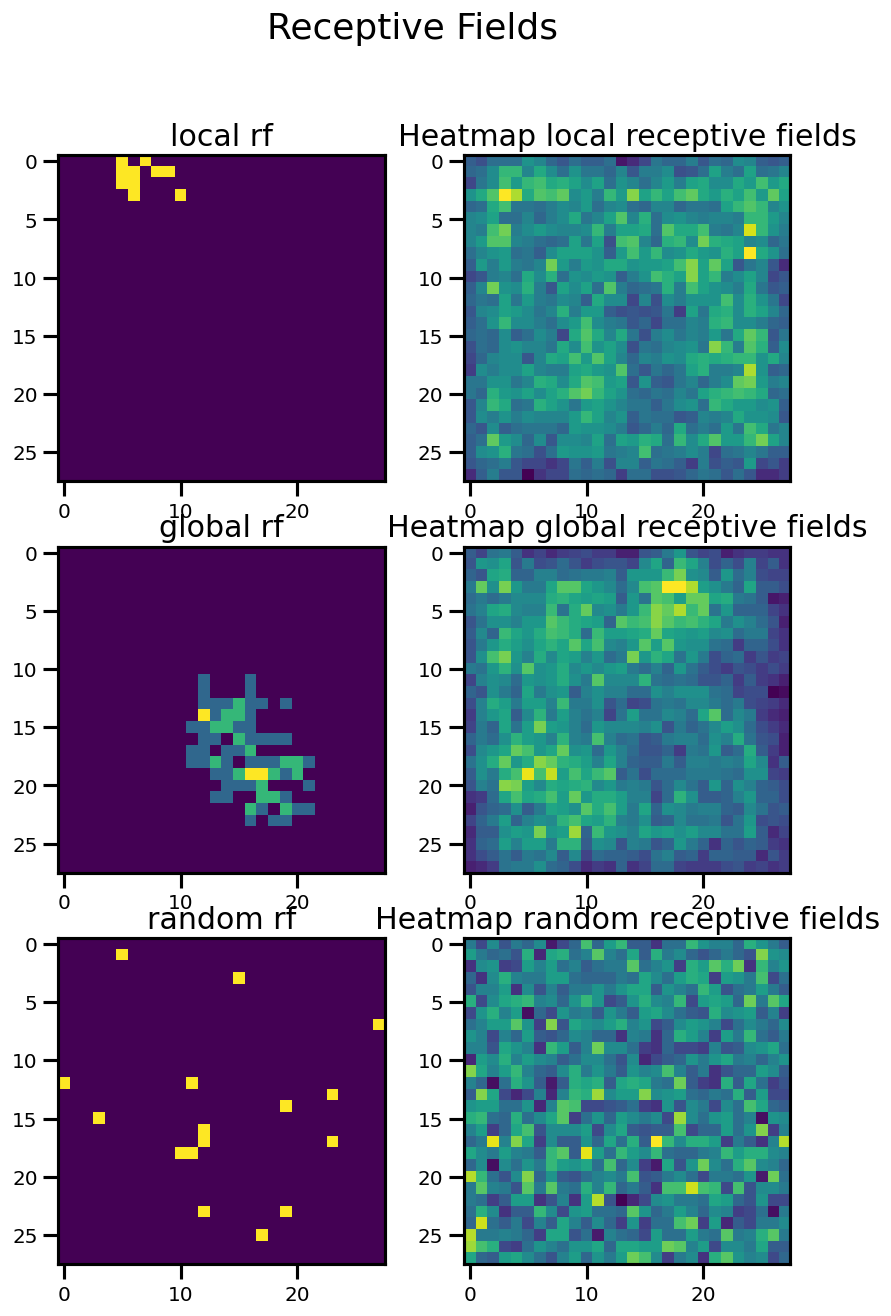

In [36]:
from masks import rf_mask, somatic_mask
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import math
img_size = 28
num_somas = 128
num_dendrites = 1024
connectivity = math.ceil(num_dendrites / num_somas)
print(connectivity)
d_local_mask = rf_mask([img_size,img_size], num_dendrites, num_somas,type='local', rf_size=16)
d_random_mask = rf_mask([img_size,img_size], num_dendrites, num_somas,type='random', rf_size=16)
d_global_mask = rf_mask([img_size,img_size], num_dendrites, num_somas,type='global', rf_size=16)
s_mask = somatic_mask(40, 20)
local_rf = d_local_mask[0].view(28,28)
local_summed = torch.sum(d_local_mask.view(-1, 28, 28), dim=0)
global_rf = torch.sum(d_global_mask[0:connectivity].view(-1, 28,28), dim=0)
global_summed = torch.sum(d_global_mask.view(-1, 28, 28), dim=0)
random_rf = d_random_mask[0].view(28,28)
random_summed = torch.sum(d_random_mask.view(-1, 28, 28), dim=0)


sns.set_context("talk") 

plt.rcParams.update({
    'figure.figsize':   (8, 12),   # 
    'figure.dpi':       120,
    'axes.titlesize':   18,
    'axes.labelsize':   14,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'lines.markersize': 6,
    'lines.linewidth':  1.5,
})


fig, axs = plt.subplots(3,2)
fig.suptitle('Receptive Fields')
axs[0,0].imshow(local_rf)
axs[0,0].set_title('local rf')
axs[0,1].imshow(local_summed)
axs[0,1].set_title('Heatmap local receptive fields')
axs[1,0].imshow(global_rf)
axs[1,0].set_title('global rf')
axs[1,1].imshow(global_summed)
axs[1,1].set_title('Heatmap global receptive fields')
axs[2,0].imshow(random_rf)
axs[2,0].set_title('random rf')
axs[2,1].imshow(random_summed)
axs[2,1].set_title('Heatmap random receptive fields')

plt.show()

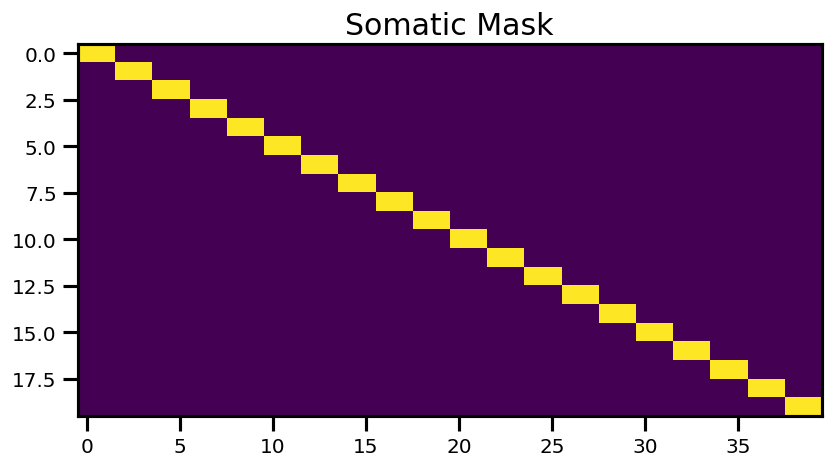

In [37]:
plt.imshow(s_mask)
plt.title('Somatic Mask')
plt.show()

### Training
I trained models across a range of parameter configurations for 20 epochs with 5 model types. Dendritic ANNs (dANN) with global, local and random RFs, a standart ANN with the same parameters but no masks (vANN) and a vANN with L2 regularization as the rf masks from a ML perspective are a form of regularization and I wanted to compare it with a different regularized model. I trained on Fashion MNIST as its easy to work with and maybe has a bit richer features then regular MNIST. 
### Results:

In [2]:
import numpy as np
import pandas as pd
results  = pd.read_csv('./results.csv')

In [16]:
results.describe()

,Epoch,Test Loss,Accuracy,Num Dendrites,Num Somas,Total Parameters
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2.400000e+03
mean,9.500000,0.383025,0.865553,4080.000000,1190.000000,1.626465e+07
std,5.767483,0.082696,0.031902,5301.308324,1865.108423,3.322309e+07
min,0.000000,0.271335,0.617000,128.000000,16.000000,1.027140e+05
25%,4.750000,0.333383,0.854800,448.000000,112.000000,3.853380e+05
50%,9.500000,0.359384,0.874100,1536.000000,384.000000,1.734282e+06
75%,14.250000,0.410276,0.886800,5120.000000,1280.000000,1.242753e+07
max,19.000000,0.991330,0.908000,16384.000000,8192.000000,1.471693e+08


In [6]:
results['RF Type'] = results['RF Type'].fillna('none')

results['dend_per_soma'] = results['Num Dendrites'] / results['Num Somas']

conditions = [
    (results['RF Type']=='local') | (results['RF Type']=='global'),
    (results['RF Type']=='random'),
    (results['RF Type']=='none')
]
choices = [
    results['Total Parameters'] * 0.0152,
    results['Total Parameters'] * 0.0214,
    results['Total Parameters'] 
]
results['Trainable Parameters'] = np.select(conditions, choices, default=np.nan)

results['model'] = np.select(
    [
        (results['Model Type']=='dendritic') & (results['RF Type']=='local'),
        (results['Model Type']=='dendritic') & (results['RF Type']=='global'),
        (results['Model Type']=='dendritic') & (results['RF Type']=='random'),
        (results['Model Type']=='vanilla')   & (results['Regularized']==False),
        (results['Model Type']=='vanilla')   & (results['Regularized']==True)
    ],
    ['dANN local','dANN global','dANN random','vANN','vANN + L2'],
    default=None
)


config_cols = ['Num Dendrites', 'Num Somas', 'Regularized', 'RF Type']
best_acc_per_config = results.loc[
    results.groupby(config_cols)['Accuracy'].idxmax()
].reset_index(drop=True)
best_loss_per_config = results.loc[
    results.groupby(config_cols)['Test Loss'].idxmin()
].reset_index(drop=True)



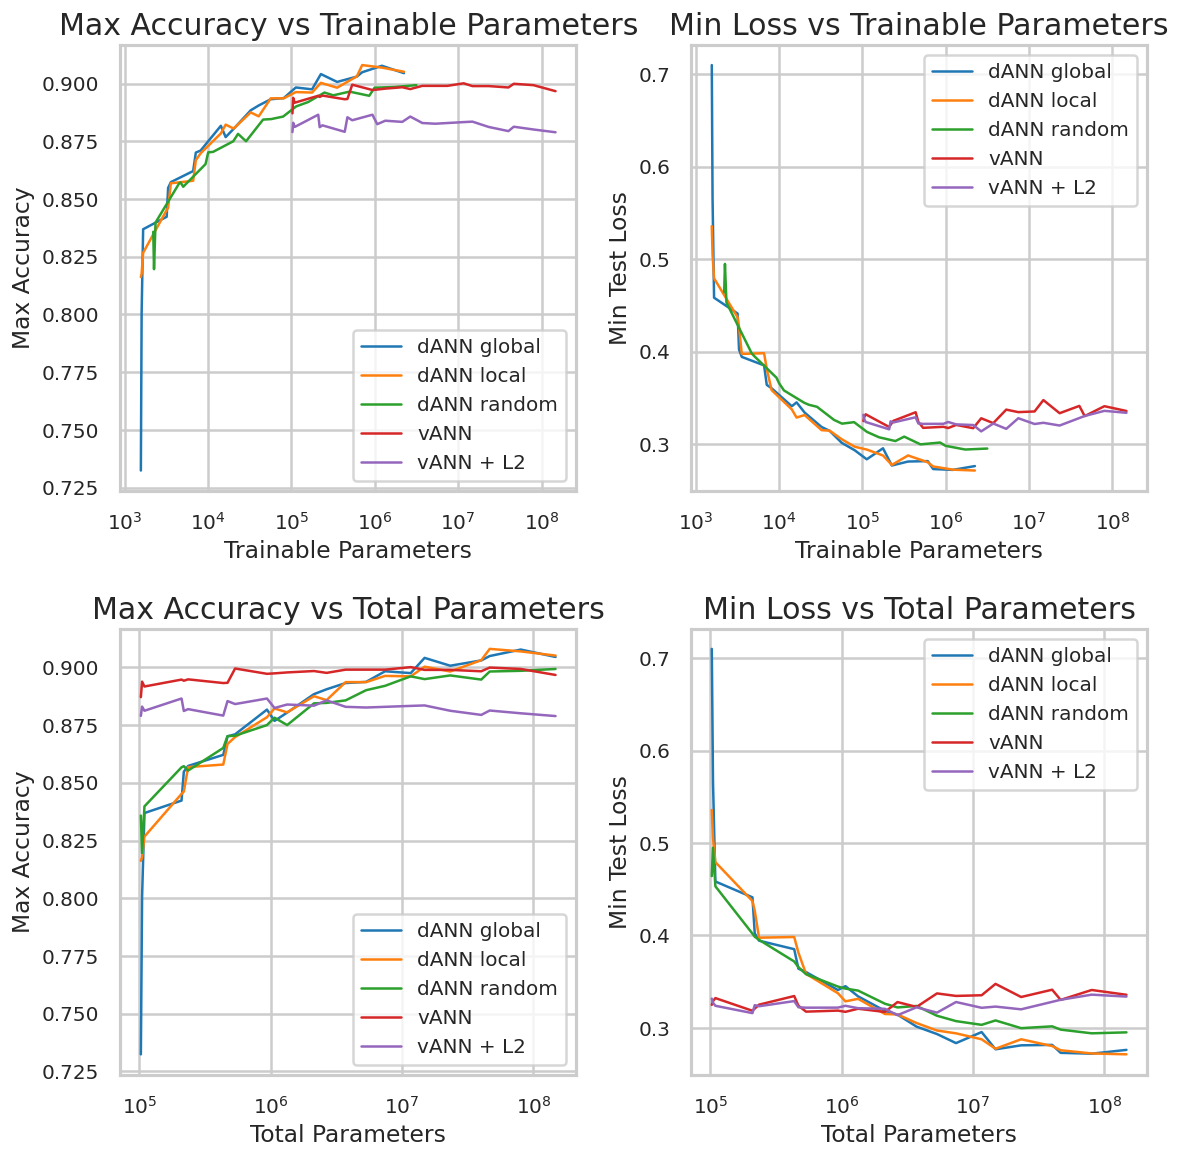

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Max Accuracy vs Trainable Parameters
for label, grp in best_acc_per_config.groupby('model'):
    grp = grp.sort_values('Trainable Parameters')
    axs[0,0].plot(grp['Trainable Parameters'], grp['Accuracy'], label=label)
axs[0,0].set_xlabel('Trainable Parameters')
axs[0,0].set_ylabel('Max Accuracy')
axs[0,0].set_title('Max Accuracy vs Trainable Parameters')
axs[0,0].set_xscale('log')
axs[0,0].legend()

#  Min Loss vs Trainable Parameters
for label, grp in best_loss_per_config.groupby('model'):
    grp = grp.sort_values('Trainable Parameters')
    axs[0,1].plot(grp['Trainable Parameters'], grp['Test Loss'], label=label)
axs[0,1].set_xlabel('Trainable Parameters')
axs[0,1].set_ylabel('Min Test Loss')
axs[0,1].set_title('Min Loss vs Trainable Parameters')
axs[0,1].set_xscale('log')
axs[0,1].legend()

#  Max Accuracy vs Total Parameters
for label, grp in best_acc_per_config.groupby('model'):
    grp = grp.sort_values('Total Parameters')
    axs[1,0].plot(grp['Total Parameters'], grp['Accuracy'], label=label)
axs[1,0].set_xlabel('Total Parameters')
axs[1,0].set_ylabel('Max Accuracy')
axs[1,0].set_title('Max Accuracy vs Total Parameters')
axs[1,0].set_xscale('log')
axs[1,0].legend()

# Min Loss vs Total Parameters
for label, grp in best_loss_per_config.groupby('model'):
    grp = grp.sort_values('Total Parameters')
    axs[1,1].plot(grp['Total Parameters'], grp['Test Loss'], label=label)
axs[1,1].set_xlabel('Total Parameters')
axs[1,1].set_ylabel('Min Test Loss')
axs[1,1].set_title('Min Loss vs Total Parameters')
axs[1,1].set_xscale('log')
axs[1,1].legend()

plt.tight_layout()
plt.show()

When we plot the number of trainable parameters vs accuracy / loss we can see a similar results as is reported in the paper. The number of trainable parameters needed for a dANN is quite a bit lower than for the vANN counterparts. Interestingly the vANN with regularization performed a lot worse than all other models, probably due to the fact that the models are not that overfitted yet and I used regular Adam instead of AdamW, so the added loss term is just "distracting" from the main objective. Local and global RFs achieved the highest accuracy and performed very similar overall with random RF models falling a bit behind. 

### Convergence

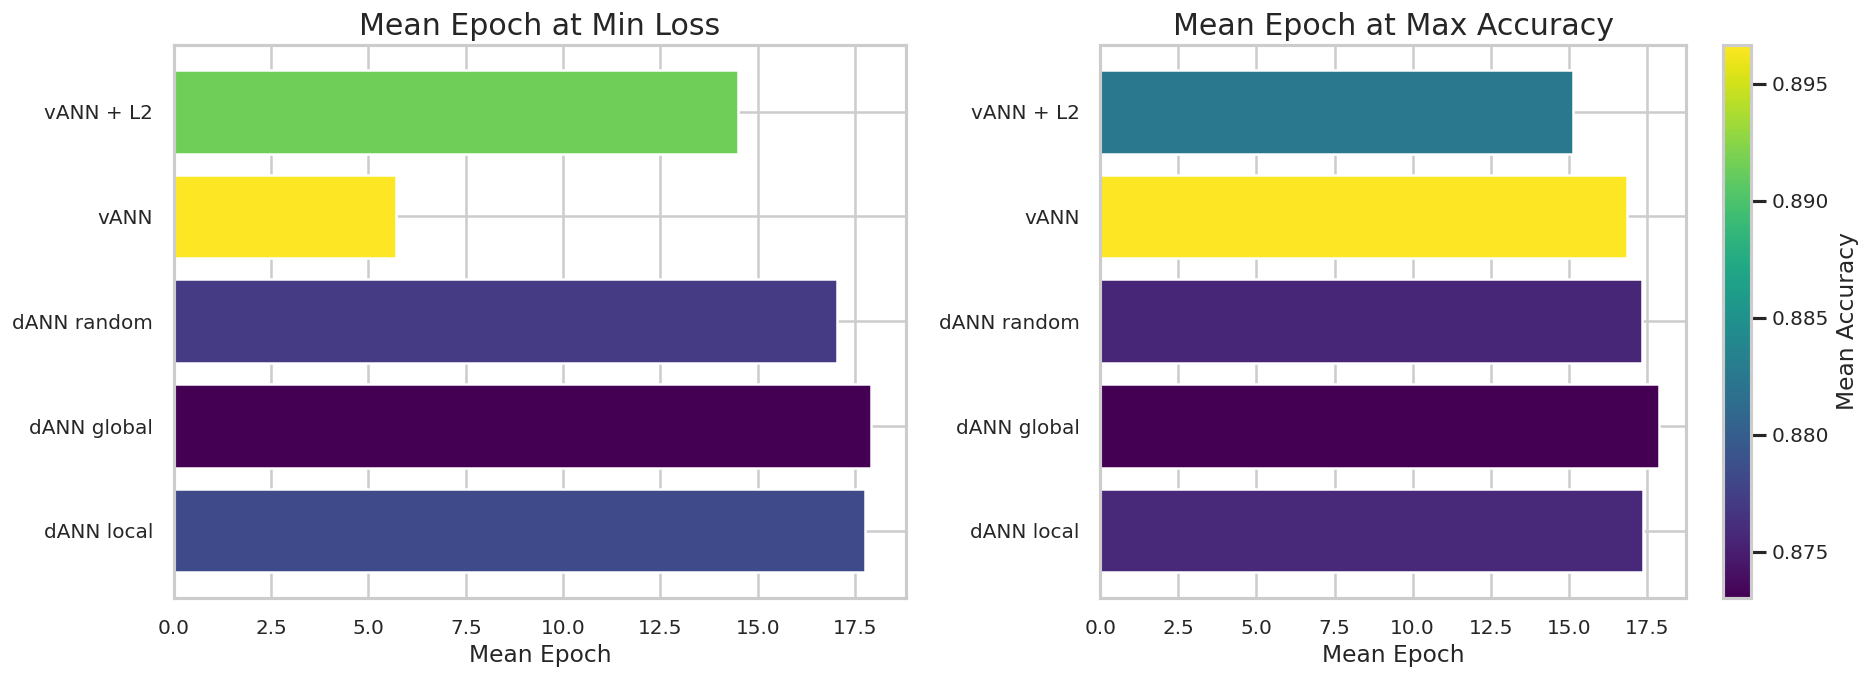

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

models = ['dANN local','dANN global','dANN random','vANN','vANN + L2']

# 1) Loss‐based summary
summary_loss = best_loss_per_config.groupby('model').agg({
    'Epoch':'mean','Accuracy':'mean'
}).reindex(models)
mean_epoch_loss = summary_loss['Epoch']
mean_acc_loss   = summary_loss['Accuracy']

# 2) Accuracy‐based summary
summary_acc = best_acc_per_config.groupby('model').agg({
    'Epoch':'mean','Accuracy':'mean'
}).reindex(models)
mean_epoch_acc = summary_acc['Epoch']
mean_acc_acc   = summary_acc['Accuracy']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

cmap = plt.cm.viridis

# Left plot: Loss‐based
norm0    = plt.Normalize(vmin=mean_acc_loss.min(), vmax=mean_acc_loss.max())
colors0  = cmap(norm0(mean_acc_loss.values))
axs[0].barh(mean_epoch_loss.index, mean_epoch_loss.values, color=colors0)
axs[0].set_title('Mean Epoch at Min Loss')
axs[0].set_xlabel('Mean Epoch')
sm0 = plt.cm.ScalarMappable(cmap=cmap, norm=norm0)
sm0.set_array([])

# Right plot: Accuracy‐based
norm1    = plt.Normalize(vmin=mean_acc_acc.min(), vmax=mean_acc_acc.max())
colors1  = cmap(norm1(mean_acc_acc.values))
axs[1].barh(mean_epoch_acc.index, mean_epoch_acc.values, color=colors1)
axs[1].set_title('Mean Epoch at Max Accuracy')
axs[1].set_xlabel('Mean Epoch')
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=axs[1], pad=0.05).set_label('Mean Accuracy')

plt.tight_layout()
plt.show()

The vANN models appear to have converged ealier on average then the dANN ones. This seems fitting as the masks are a form of regularization so the vANN models are possibly overfitting after a certain number of epochs. The average loss accuracy of the dANNs is quite a bit lower, which can be explained by the fact that the smaller models in the dataset are outperformed by their none pruned counterparts of the same size.  

#### Dendrites per soma

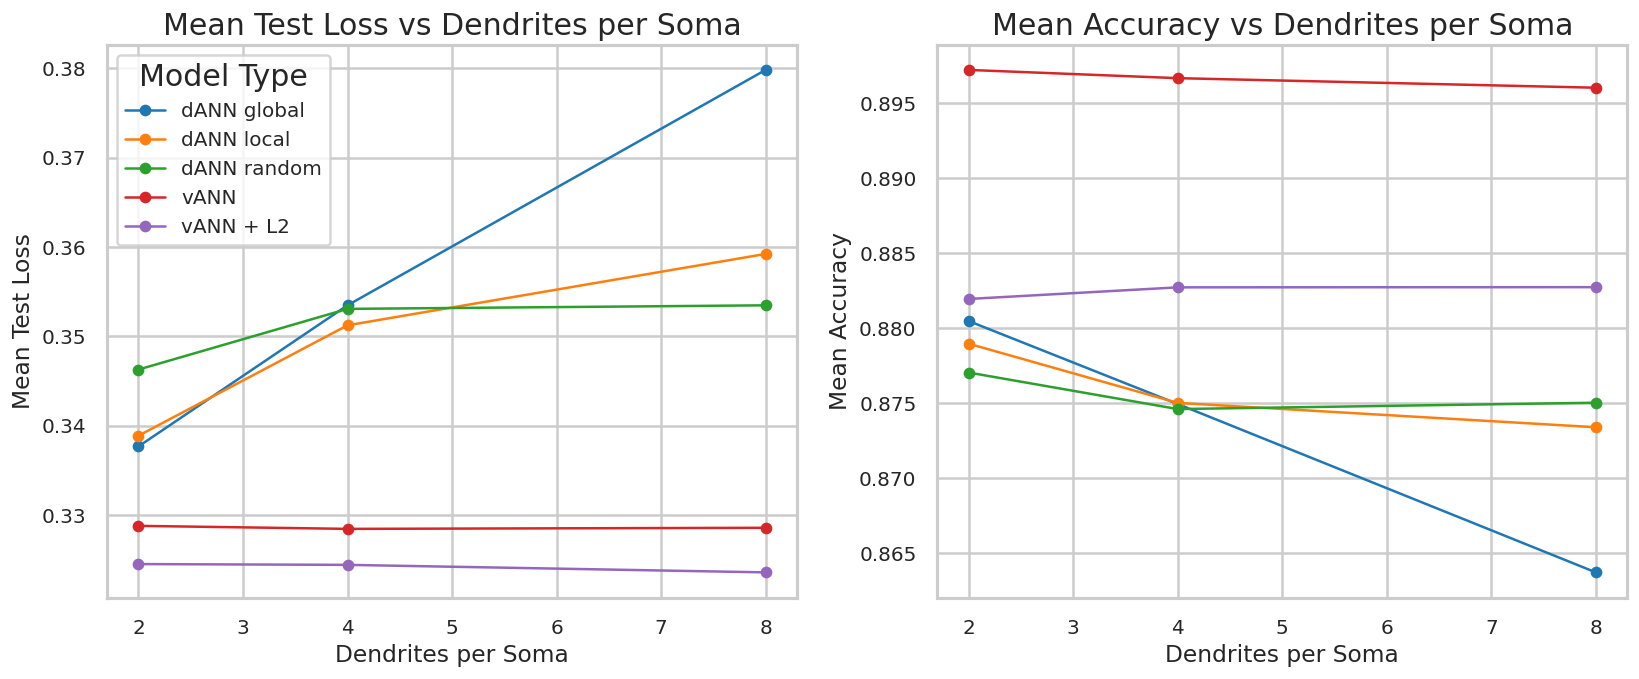

In [21]:
mean_loss = best_loss_per_config.groupby(
    ['model','dend_per_soma']
)['Test Loss'] \
 .mean() \
 .reset_index()
mean_acc_dp = best_acc_per_config.groupby(
    ['model','dend_per_soma']
)['Accuracy'].mean().reset_index()
# Mean Loss
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for label, grp in mean_loss.groupby('model'):
    grp = grp.sort_values('dend_per_soma')
    axs[0].plot(
        grp['dend_per_soma'],
        grp['Test Loss'],
        marker='o',
        label=label
    )
axs[0].set_xlabel('Dendrites per Soma')
axs[0].set_ylabel('Mean Test Loss')
axs[0].set_title('Mean Test Loss vs Dendrites per Soma')
axs[0].legend(title='Model Type')

 # Mean Accuracy
for label, grp in mean_acc_dp.groupby('model'):
    grp = grp.sort_values('dend_per_soma')
    axs[1].plot(
        grp['dend_per_soma'],
        grp['Accuracy'],
        marker='o',
        label=label
    )
axs[1].set_xlabel('Dendrites per Soma')
axs[1].set_ylabel('Mean Accuracy')
axs[1].set_title('Mean Accuracy vs Dendrites per Soma')

plt.tight_layout()
plt.show()

We can see that ratio of dendrites per somas has no effect on the vANN models, which is somewhat expected as they are fully connected. The dANN models clearly prefer a lower number of connections per soma, contrary to the paper. This is quite unexpected that the models perform best with such limited connectivity, but could be viewed as a pointer that the fixed dendrite like structure is actually a useful architectural bias. Considering that there are only 3 parameter sizes for dendrites per soma and the contradiction with the results from the paper further testing would be needed here.  

### Conclusion

All in all the results are in-line with the paper for the most part. dANNs require less trainable parameters then unmodified ANNs and the dendritic tree like structure actually seems to help. The authors also observed a larger performance gain with increases task difficulty, so training on for example a naturalistic dataset could be interesting. Pytorch does also support sparse x dense matrix multiplication so a comparison in performance during training and inference would be interesting here, since using regular matmul operations won't really result in increased efficiency for dANN. 

The code for this project can be found at: https://github.com/Elias-desig/dANN